In [1]:
from model.my_model import MyModel
from data_preparation.utils import DataPipeline, BatchPipeline

In [2]:
train_file_name = 'train.csv'
test_file_name = 'test.csv'
sample_submission_file_name = 'sample_submission.csv'

In [3]:
data_pipeline = DataPipeline(train_file_name, test_file_name, sample_submission_file_name)

2022-01-18 19:33:21.483665: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 19:33:21.526376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 19:33:21.526645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 19:33:21.527299: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Getting the file: /home/sersery/Desktop/TUM Informatik/WS2122/Applied Deep Learning for NLP/KAGGLE_NLP_with_disaster_tweets/data/train.csv
-----------------------------------------------------------------------------------------
Dataset 
Size: 7613
Dataset examples:
Input: [ 582 1716    1    1    1  662   99  145   87    1  662    1    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
Target: [0. 1.]

<AxesSubplot:>

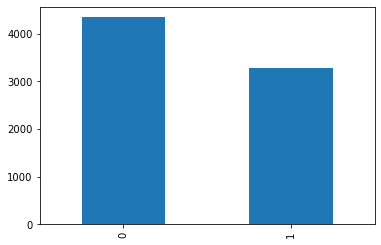

In [4]:
data_pipeline.dataframe["target"].value_counts().plot(kind='bar')

# It can be easily seen that the classes are not distributed evenly.

In [8]:
isTrueCount = data_pipeline.dataframe["target"].where(data_pipeline.dataframe["target"] == 1).count()
isFalseCount = data_pipeline.dataframe["target"].where(data_pipeline.dataframe["target"] == 0).count()
print(f"True instances: {isTrueCount} | {100 * isTrueCount / (isTrueCount + isFalseCount)}% of data")
print(f"False instances: {isFalseCount} | {100 * isFalseCount / (isTrueCount + isFalseCount)}% of data")

True instances: 3271 | 42.965979246026535% of data
False instances: 4342 | 57.034020753973465% of data


# However the difference is not that big. But we apply some class_weights for this uneven distribution.

In [4]:
from tensorboard.plugins.hparams import api as hp
import tensorflow as tf

print(f"Vocabulary size: {data_pipeline.vocabulary_size}")
parameters = {
    "vocabulary_size": data_pipeline.vocabulary_size,
    "embedding_dim": 32,
    "n_labels": 2,
    "epochs": 3,
    "n_steps": 0,
}

hyperparameters = {"learning_rate": hp.HParam("learning_rate", hp.RealInterval(1e-3, 1e-1)),
                   "hidden_unit": hp.HParam("hidden_unit", hp.Discrete([8, 16, 32, 64, 128])),
                   "batch_size": hp.HParam("batch_size", hp.Discrete([16, 32, 64])),
                   "optimizer": hp.HParam("optimizer", hp.Discrete(["adam", "adamw", "sgd"]))}



Vocabulary size: 5001


In [5]:
log_directory = "./logs/hyperparameter_tuning/"
with tf.summary.create_file_writer(log_directory).as_default():
    hp.hparams_config(
        hparams=hyperparameters.values(),
        metrics=[hp.Metric("accuracy", display_name="Accuracy"),
                 hp.Metric("precision", display_name="Precision"),
                 hp.Metric("recall", display_name="Recall"),
                 hp.Metric("f1", display_name="F1 Score")])

In [6]:
# look for the best hyperparameters
for optimizer in hyperparameters["optimizer"].domain.values:
    for hidden_unit in hyperparameters["hidden_unit"].domain.values:
        for batch_size in hyperparameters["batch_size"].domain.values:
            for learning_rate in (hyperparameters["learning_rate"].domain.min_value, hyperparameters["learning_rate"].domain.max_value):
                hparams = {
                    hyperparameters["optimizer"]: optimizer,
                    hyperparameters["hidden_unit"]: hidden_unit,
                    hyperparameters["batch_size"]: batch_size,
                    hyperparameters["learning_rate"]: learning_rate
                }
                my_model = MyModel(batch_pipeline=BatchPipeline(data_pipeline.dataset, batch_size),
                                   parameters=parameters,
                                   hyperparameters=hyperparameters,
                                   hparams=hparams)

                with tf.summary.create_file_writer(f'{log_directory}{my_model.run_name}').as_default():
                    hp.hparams(hparams)
                    accuracy, precision, recall, f1 = my_model.fit_model_and_evaluate(log_directory=log_directory)
                    tf.summary.scalar("accuracy", accuracy, step=1)
                    tf.summary.scalar("precision", precision, step=1)
                    tf.summary.scalar("recall", recall, step=1)
                    tf.summary.scalar("f1", f1, step=1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          160032    
                                                                 
 masking (Masking)           (None, None, 32)          0         
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
Total params: 160,314
Trainable params: 160,314
Non-trainable params: 0
__________________________________________________

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 3s 17ms/step - loss: 0.5569 - accuracy: 0.7102 - val_loss: 0.3725 - val_accuracy: 0.8523
Epoch 2/3
95/95 [==============================] - 0s 5ms/step - loss: 0.3607 - accuracy: 0.8444 - val_loss: 0.2956 - val_accuracy: 0.8707
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.3283 - accuracy: 0.8651
run=0__lr=0.1__hidden_unit=8__optimizer=adam completed.
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 32)          160032    
                                                                 
 masking_8 (Masking)         (None, None, 32)          0         
                                                                 
 global_average_pooling1d_8   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                            

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


47/47 [==============================] - 3s 31ms/step - loss: 0.5932 - accuracy: 0.6727 - val_loss: 0.3877 - val_accuracy: 0.8547
Epoch 2/3
47/47 [==============================] - 0s 6ms/step - loss: 0.3795 - accuracy: 0.8374 - val_loss: 0.2684 - val_accuracy: 0.8938
Epoch 3/3
5/5 [==============================] - 1s 2ms/step - loss: 0.4045 - accuracy: 0.8375
run=0__lr=0.1__hidden_unit=8__optimizer=adam completed.
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_10 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_10  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                             

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


47/47 [==============================] - 3s 34ms/step - loss: 0.5735 - accuracy: 0.6943 - val_loss: 0.3929 - val_accuracy: 0.8328
Epoch 2/3
47/47 [==============================] - 0s 6ms/step - loss: 0.3728 - accuracy: 0.8393 - val_loss: 0.3125 - val_accuracy: 0.8781
Epoch 3/3
5/5 [==============================] - 1s 2ms/step - loss: 0.3203 - accuracy: 0.8703
run=0__lr=0.1__hidden_unit=16__optimizer=adam completed.
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_20 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_20  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                            

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


47/47 [==============================] - 4s 45ms/step - loss: 0.5986 - accuracy: 0.6689 - val_loss: 0.4021 - val_accuracy: 0.8406
Epoch 2/3
47/47 [==============================] - 0s 7ms/step - loss: 0.3624 - accuracy: 0.8449 - val_loss: 0.3363 - val_accuracy: 0.8781
Epoch 3/3
5/5 [==============================] - 2s 2ms/step - loss: 0.3246 - accuracy: 0.8750
run=0__lr=0.1__hidden_unit=32__optimizer=adam completed.
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_30 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_30  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                            

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


47/47 [==============================] - 4s 42ms/step - loss: 0.6020 - accuracy: 0.6622 - val_loss: 0.3787 - val_accuracy: 0.8625
Epoch 2/3
47/47 [==============================] - 0s 7ms/step - loss: 0.3663 - accuracy: 0.8398 - val_loss: 0.2763 - val_accuracy: 0.8922
Epoch 3/3
5/5 [==============================] - 2s 2ms/step - loss: 0.3468 - accuracy: 0.9031
run=0__lr=0.1__hidden_unit=64__optimizer=adam completed.
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_40 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_40  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                            

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


47/47 [==============================] - 4s 41ms/step - loss: 0.6205 - accuracy: 0.6629 - val_loss: 0.4149 - val_accuracy: 0.8219
Epoch 2/3
47/47 [==============================] - 0s 6ms/step - loss: 0.3903 - accuracy: 0.8318 - val_loss: 0.3861 - val_accuracy: 0.8500
Epoch 3/3
5/5 [==============================] - 2s 3ms/step - loss: 0.3914 - accuracy: 0.8031
run=0__lr=0.1__hidden_unit=128__optimizer=adam completed.
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_50 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_50 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_50  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                           

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 5s 12ms/step - loss: 0.5936 - accuracy: 0.6727 - val_loss: 0.3966 - val_accuracy: 0.8315
Epoch 2/3
190/190 [==============================] - 1s 5ms/step - loss: 0.4087 - accuracy: 0.8258 - val_loss: 0.3488 - val_accuracy: 0.8451
Epoch 3/3
23/23 [==============================] - 1s 2ms/step - loss: 0.2725 - accuracy: 0.8859
run=0__lr=0.1__hidden_unit=8__optimizer=adamw completed.
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_56 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_56 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_56  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                      

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 22ms/step - loss: 0.5910 - accuracy: 0.6839 - val_loss: 0.3966 - val_accuracy: 0.8338
Epoch 2/3
95/95 [==============================] - 1s 5ms/step - loss: 0.3859 - accuracy: 0.8298 - val_loss: 0.3018 - val_accuracy: 0.8849
Epoch 3/3
11/11 [==============================] - 2s 2ms/step - loss: 0.3517 - accuracy: 0.8622
run=0__lr=0.1__hidden_unit=8__optimizer=adamw completed.
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_58 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_58 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_58  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                          

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


47/47 [==============================] - 4s 44ms/step - loss: 0.6531 - accuracy: 0.6065 - val_loss: 0.5149 - val_accuracy: 0.7359
Epoch 2/3
47/47 [==============================] - 0s 8ms/step - loss: 0.4446 - accuracy: 0.7994 - val_loss: 0.3816 - val_accuracy: 0.8328
Epoch 3/3
5/5 [==============================] - 2s 3ms/step - loss: 0.3369 - accuracy: 0.8687
run=0__lr=0.1__hidden_unit=8__optimizer=adamw completed.
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_60 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_60 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_60  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                            

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 5s 13ms/step - loss: 0.5443 - accuracy: 0.7102 - val_loss: 0.3695 - val_accuracy: 0.8288
Epoch 2/3
190/190 [==============================] - 1s 5ms/step - loss: 0.3776 - accuracy: 0.8327 - val_loss: 0.3425 - val_accuracy: 0.8410
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.2858 - accuracy: 0.8872
run=0__lr=0.1__hidden_unit=16__optimizer=adamw completed.
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_66 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_66 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_66  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                     

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 23ms/step - loss: 0.6078 - accuracy: 0.6548 - val_loss: 0.4764 - val_accuracy: 0.7585
Epoch 2/3
95/95 [==============================] - 1s 5ms/step - loss: 0.3993 - accuracy: 0.8232 - val_loss: 0.3203 - val_accuracy: 0.8707
Epoch 3/3
11/11 [==============================] - 2s 2ms/step - loss: 0.3249 - accuracy: 0.8807
run=0__lr=0.1__hidden_unit=16__optimizer=adamw completed.
Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_68 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_68 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_68  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                         

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


47/47 [==============================] - 5s 44ms/step - loss: 0.6379 - accuracy: 0.6351 - val_loss: 0.4770 - val_accuracy: 0.7984
Epoch 2/3
47/47 [==============================] - 0s 7ms/step - loss: 0.4071 - accuracy: 0.8235 - val_loss: 0.3613 - val_accuracy: 0.8297
Epoch 3/3
5/5 [==============================] - 2s 3ms/step - loss: 0.3066 - accuracy: 0.8938
run=0__lr=0.1__hidden_unit=16__optimizer=adamw completed.
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_70 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_70 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_70  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                           

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 5s 14ms/step - loss: 0.5860 - accuracy: 0.6727 - val_loss: 0.4188 - val_accuracy: 0.8342
Epoch 2/3
190/190 [==============================] - 1s 4ms/step - loss: 0.3967 - accuracy: 0.8273 - val_loss: 0.3240 - val_accuracy: 0.8641
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.2514 - accuracy: 0.9035
run=0__lr=0.1__hidden_unit=32__optimizer=adamw completed.
Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_76 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_76 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_76  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                     

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 5s 23ms/step - loss: 0.5760 - accuracy: 0.6831 - val_loss: 0.3957 - val_accuracy: 0.8182
Epoch 2/3
95/95 [==============================] - 1s 6ms/step - loss: 0.3915 - accuracy: 0.8308 - val_loss: 0.3338 - val_accuracy: 0.8679
Epoch 3/3
11/11 [==============================] - 2s 3ms/step - loss: 0.3099 - accuracy: 0.8849
run=0__lr=0.1__hidden_unit=32__optimizer=adamw completed.
Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_78 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_78 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_78  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                         

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


47/47 [==============================] - 4s 44ms/step - loss: 0.6367 - accuracy: 0.6134 - val_loss: 0.4993 - val_accuracy: 0.7422
Epoch 2/3
47/47 [==============================] - 0s 7ms/step - loss: 0.4123 - accuracy: 0.8188 - val_loss: 0.3965 - val_accuracy: 0.8141
Epoch 3/3
5/5 [==============================] - 2s 3ms/step - loss: 0.3215 - accuracy: 0.8687
run=0__lr=0.1__hidden_unit=32__optimizer=adamw completed.
Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_80 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_80 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_80  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                           

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 13ms/step - loss: 0.5803 - accuracy: 0.6931 - val_loss: 0.4046 - val_accuracy: 0.8451
Epoch 2/3
190/190 [==============================] - 1s 5ms/step - loss: 0.3791 - accuracy: 0.8370 - val_loss: 0.3915 - val_accuracy: 0.8057
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.2609 - accuracy: 0.9049
run=0__lr=0.1__hidden_unit=64__optimizer=adamw completed.
Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_86 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_86 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_86  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                     

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 23ms/step - loss: 0.5846 - accuracy: 0.6789 - val_loss: 0.3800 - val_accuracy: 0.8352
Epoch 2/3
95/95 [==============================] - 1s 6ms/step - loss: 0.3875 - accuracy: 0.8398 - val_loss: 0.3137 - val_accuracy: 0.8864
Epoch 3/3
11/11 [==============================] - 2s 2ms/step - loss: 0.3138 - accuracy: 0.8807
run=0__lr=0.1__hidden_unit=64__optimizer=adamw completed.
Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_88 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_88 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_88  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                         

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


47/47 [==============================] - 5s 48ms/step - loss: 0.6365 - accuracy: 0.6325 - val_loss: 0.4134 - val_accuracy: 0.8078
Epoch 2/3
47/47 [==============================] - 0s 7ms/step - loss: 0.4216 - accuracy: 0.8117 - val_loss: 0.3657 - val_accuracy: 0.8375
Epoch 3/3
5/5 [==============================] - 2s 2ms/step - loss: 0.2806 - accuracy: 0.8906
run=0__lr=0.1__hidden_unit=64__optimizer=adamw completed.
Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_90 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_90 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_90  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                           

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 5s 13ms/step - loss: 0.5922 - accuracy: 0.6781 - val_loss: 0.4657 - val_accuracy: 0.8125
Epoch 2/3
190/190 [==============================] - 1s 4ms/step - loss: 0.4039 - accuracy: 0.8258 - val_loss: 0.4289 - val_accuracy: 0.8342
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.3106 - accuracy: 0.8791
run=0__lr=0.1__hidden_unit=128__optimizer=adamw completed.
Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_96 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_96 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_96  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                    

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 5s 24ms/step - loss: 0.5989 - accuracy: 0.6735 - val_loss: 0.3879 - val_accuracy: 0.8395
Epoch 2/3
95/95 [==============================] - 1s 6ms/step - loss: 0.3805 - accuracy: 0.8414 - val_loss: 0.3361 - val_accuracy: 0.8594
Epoch 3/3
11/11 [==============================] - 2s 2ms/step - loss: 0.2827 - accuracy: 0.8935
run=0__lr=0.1__hidden_unit=128__optimizer=adamw completed.
Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_98 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_98 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_98  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                        

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


47/47 [==============================] - 5s 47ms/step - loss: 0.6246 - accuracy: 0.6576 - val_loss: 0.4575 - val_accuracy: 0.8141
Epoch 2/3
47/47 [==============================] - 1s 12ms/step - loss: 0.3957 - accuracy: 0.8286 - val_loss: 0.3244 - val_accuracy: 0.8719
Epoch 3/3
5/5 [==============================] - 2s 3ms/step - loss: 0.3168 - accuracy: 0.8750
run=0__lr=0.1__hidden_unit=128__optimizer=adamw completed.
Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_100 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_100 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_10  (None, 32)               0         
 0 (GlobalAveragePooling1D)                                      
                        

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


761/761 [==============================] - 7s 6ms/step - loss: 0.6849 - accuracy: 0.5683 - val_loss: 0.6809 - val_accuracy: 0.5816
Epoch 2/3
761/761 [==============================] - 3s 4ms/step - loss: 0.6846 - accuracy: 0.5683 - val_loss: 0.6809 - val_accuracy: 0.5816
Epoch 3/3
95/95 [==============================] - 2s 2ms/step - loss: 0.6866 - accuracy: 0.5566
run=0__lr=0.1__hidden_unit=8__optimizer=sgd completed.
Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_102 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_102 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_10  (None, 32)               0         
 2 (GlobalAveragePooling1D)                                      
                        

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 6s 9ms/step - loss: 0.6916 - accuracy: 0.5689 - val_loss: 0.6918 - val_accuracy: 0.5465
Epoch 2/3
380/380 [==============================] - 2s 4ms/step - loss: 0.6907 - accuracy: 0.5689 - val_loss: 0.6913 - val_accuracy: 0.5465
Epoch 3/3
47/47 [==============================] - 2s 2ms/step - loss: 0.6904 - accuracy: 0.5545
run=0__lr=0.001__hidden_unit=8__optimizer=sgd completed.


/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential_103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_103 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_103 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_10  (None, 32)               0         
 3 (GlobalAveragePooling1D)                                      
                                                                 
 dense_206 (Dense)           (None, 8)                 264       
                                                                 
 dense_207 (Dense)           (None, 2)                 18        
                                                                 
Total params: 160,314
Trainable params: 160,314
Non-trainable params: 0
______________________________________________

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 5s 13ms/step - loss: 0.6939 - accuracy: 0.4414 - val_loss: 0.6929 - val_accuracy: 0.5788
Epoch 2/3
190/190 [==============================] - 1s 4ms/step - loss: 0.6923 - accuracy: 0.5712 - val_loss: 0.6917 - val_accuracy: 0.5774
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.6901 - accuracy: 0.5992
run=0__lr=0.001__hidden_unit=8__optimizer=sgd completed.
Model: "sequential_105"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_105 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_105 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_10  (None, 32)               0         
 5 (GlobalAveragePooling1D)                                      
                     

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 13ms/step - loss: 0.6852 - accuracy: 0.5681 - val_loss: 0.6799 - val_accuracy: 0.5829
Epoch 2/3
190/190 [==============================] - 1s 4ms/step - loss: 0.6835 - accuracy: 0.5699 - val_loss: 0.6796 - val_accuracy: 0.5829
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.6820 - accuracy: 0.5747
run=0__lr=0.1__hidden_unit=8__optimizer=sgd completed.
Model: "sequential_106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_106 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_106 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_10  (None, 32)               0         
 6 (GlobalAveragePooling1D)                                      
                       

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 22ms/step - loss: 0.6932 - accuracy: 0.4926 - val_loss: 0.6930 - val_accuracy: 0.5781
Epoch 2/3
95/95 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5668 - val_loss: 0.6927 - val_accuracy: 0.5781
Epoch 3/3
11/11 [==============================] - 2s 2ms/step - loss: 0.6929 - accuracy: 0.5312
run=0__lr=0.001__hidden_unit=8__optimizer=sgd completed.
Model: "sequential_107"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_107 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_107 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_10  (None, 32)               0         
 7 (GlobalAveragePooling1D)                                      
                         

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 22ms/step - loss: 0.6863 - accuracy: 0.5668 - val_loss: 0.6867 - val_accuracy: 0.5568
Epoch 2/3
95/95 [==============================] - 0s 5ms/step - loss: 0.6831 - accuracy: 0.5714 - val_loss: 0.6870 - val_accuracy: 0.5568
Epoch 3/3
11/11 [==============================] - 2s 2ms/step - loss: 0.6780 - accuracy: 0.5881
run=0__lr=0.1__hidden_unit=8__optimizer=sgd completed.
Model: "sequential_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_108 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_108 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_10  (None, 32)               0         
 8 (GlobalAveragePooling1D)                                      
                           

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


47/47 [==============================] - 4s 43ms/step - loss: 0.6929 - accuracy: 0.5655 - val_loss: 0.6926 - val_accuracy: 0.5859
Epoch 2/3
47/47 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.5713 - val_loss: 0.6921 - val_accuracy: 0.5859
Epoch 3/3
5/5 [==============================] - 2s 3ms/step - loss: 0.6922 - accuracy: 0.5547
run=0__lr=0.001__hidden_unit=8__optimizer=sgd completed.
Model: "sequential_109"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_109 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_109 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_10  (None, 32)               0         
 9 (GlobalAveragePooling1D)                                      
                           

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


47/47 [==============================] - 6s 57ms/step - loss: 0.6882 - accuracy: 0.5575 - val_loss: 0.6885 - val_accuracy: 0.5484
Epoch 2/3
47/47 [==============================] - 0s 7ms/step - loss: 0.6842 - accuracy: 0.5693 - val_loss: 0.6886 - val_accuracy: 0.5484
Epoch 3/3
5/5 [==============================] - 2s 2ms/step - loss: 0.6874 - accuracy: 0.5547
run=0__lr=0.1__hidden_unit=8__optimizer=sgd completed.
Model: "sequential_110"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_110 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_110 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_11  (None, 32)               0         
 0 (GlobalAveragePooling1D)                                      
                             

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


761/761 [==============================] - 9s 9ms/step - loss: 0.6933 - accuracy: 0.5079 - val_loss: 0.6916 - val_accuracy: 0.5776
Epoch 2/3
761/761 [==============================] - 4s 5ms/step - loss: 0.6906 - accuracy: 0.5726 - val_loss: 0.6894 - val_accuracy: 0.5776
Epoch 3/3
95/95 [==============================] - 3s 3ms/step - loss: 0.6891 - accuracy: 0.5618
run=0__lr=0.001__hidden_unit=16__optimizer=sgd completed.
Model: "sequential_111"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_111 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_111 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_11  (None, 32)               0         
 1 (GlobalAveragePooling1D)                                      
                     

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


761/761 [==============================] - 9s 8ms/step - loss: 0.6846 - accuracy: 0.5683 - val_loss: 0.6846 - val_accuracy: 0.5671
Epoch 2/3
761/761 [==============================] - 4s 5ms/step - loss: 0.6842 - accuracy: 0.5696 - val_loss: 0.6845 - val_accuracy: 0.5671
Epoch 3/3
95/95 [==============================] - 2s 2ms/step - loss: 0.6822 - accuracy: 0.5776
run=0__lr=0.1__hidden_unit=16__optimizer=sgd completed.


/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential_112"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_112 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_112 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_11  (None, 32)               0         
 2 (GlobalAveragePooling1D)                                      
                                                                 
 dense_224 (Dense)           (None, 16)                528       
                                                                 
 dense_225 (Dense)           (None, 2)                 34        
                                                                 
Total params: 160,594
Trainable params: 160,594
Non-trainable params: 0
______________________________________________

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 6s 10ms/step - loss: 0.6845 - accuracy: 0.5694 - val_loss: 0.6856 - val_accuracy: 0.5625
Epoch 2/3
380/380 [==============================] - 2s 4ms/step - loss: 0.6838 - accuracy: 0.5697 - val_loss: 0.6856 - val_accuracy: 0.5625
Epoch 3/3
47/47 [==============================] - 2s 2ms/step - loss: 0.6884 - accuracy: 0.5532
run=0__lr=0.1__hidden_unit=16__optimizer=sgd completed.
Model: "sequential_114"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_114 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_114 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_11  (None, 32)               0         
 4 (GlobalAveragePooling1D)                                      
                      

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 5s 15ms/step - loss: 0.6935 - accuracy: 0.4655 - val_loss: 0.6929 - val_accuracy: 0.5503
Epoch 2/3
190/190 [==============================] - 1s 5ms/step - loss: 0.6920 - accuracy: 0.5730 - val_loss: 0.6919 - val_accuracy: 0.5503
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.6898 - accuracy: 0.5788
run=0__lr=0.001__hidden_unit=16__optimizer=sgd completed.
Model: "sequential_115"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_115 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_115 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_11  (None, 32)               0         
 5 (GlobalAveragePooling1D)                                      
                    

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 5s 15ms/step - loss: 0.6839 - accuracy: 0.5704 - val_loss: 0.6911 - val_accuracy: 0.5367
Epoch 2/3
190/190 [==============================] - 1s 5ms/step - loss: 0.6831 - accuracy: 0.5717 - val_loss: 0.6912 - val_accuracy: 0.5367
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.6860 - accuracy: 0.5598
run=0__lr=0.1__hidden_unit=16__optimizer=sgd completed.
Model: "sequential_116"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_116 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_116 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_11  (None, 32)               0         
 6 (GlobalAveragePooling1D)                                      
                      

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 5s 25ms/step - loss: 0.6942 - accuracy: 0.4273 - val_loss: 0.6935 - val_accuracy: 0.4645
Epoch 2/3
95/95 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.4273 - val_loss: 0.6933 - val_accuracy: 0.4673
Epoch 3/3
11/11 [==============================] - 2s 2ms/step - loss: 0.6929 - accuracy: 0.5568
run=0__lr=0.001__hidden_unit=16__optimizer=sgd completed.
Model: "sequential_117"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_117 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_117 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_11  (None, 32)               0         
 7 (GlobalAveragePooling1D)                                      
                        

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 24ms/step - loss: 0.6861 - accuracy: 0.5666 - val_loss: 0.6861 - val_accuracy: 0.5597
Epoch 2/3
95/95 [==============================] - 1s 5ms/step - loss: 0.6844 - accuracy: 0.5666 - val_loss: 0.6861 - val_accuracy: 0.5597
Epoch 3/3
11/11 [==============================] - 2s 2ms/step - loss: 0.6802 - accuracy: 0.5838
run=0__lr=0.1__hidden_unit=16__optimizer=sgd completed.
Model: "sequential_118"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_118 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_118 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_11  (None, 32)               0         
 8 (GlobalAveragePooling1D)                                      
                          

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


47/47 [==============================] - 4s 43ms/step - loss: 0.6900 - accuracy: 0.5665 - val_loss: 0.6906 - val_accuracy: 0.5531
Epoch 2/3
47/47 [==============================] - 0s 7ms/step - loss: 0.6897 - accuracy: 0.5665 - val_loss: 0.6904 - val_accuracy: 0.5531
Epoch 3/3
5/5 [==============================] - 2s 3ms/step - loss: 0.6893 - accuracy: 0.5656
run=0__lr=0.001__hidden_unit=16__optimizer=sgd completed.
Model: "sequential_119"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_119 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_119 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_11  (None, 32)               0         
 9 (GlobalAveragePooling1D)                                      
                          

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


47/47 [==============================] - 4s 46ms/step - loss: 0.6847 - accuracy: 0.5746 - val_loss: 0.6847 - val_accuracy: 0.5641
Epoch 2/3
47/47 [==============================] - 0s 7ms/step - loss: 0.6821 - accuracy: 0.5745 - val_loss: 0.6849 - val_accuracy: 0.5641
Epoch 3/3
5/5 [==============================] - 2s 3ms/step - loss: 0.6891 - accuracy: 0.5516
run=0__lr=0.1__hidden_unit=16__optimizer=sgd completed.
Model: "sequential_120"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_120 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_120 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_12  (None, 32)               0         
 0 (GlobalAveragePooling1D)                                      
                            

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


761/761 [==============================] - 7s 6ms/step - loss: 0.6920 - accuracy: 0.5558 - val_loss: 0.6906 - val_accuracy: 0.5697
Epoch 2/3
761/761 [==============================] - 3s 4ms/step - loss: 0.6898 - accuracy: 0.5670 - val_loss: 0.6887 - val_accuracy: 0.5697
Epoch 3/3
95/95 [==============================] - 2s 2ms/step - loss: 0.6840 - accuracy: 0.5987
run=0__lr=0.001__hidden_unit=32__optimizer=sgd completed.
Model: "sequential_121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_121 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_121 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_12  (None, 32)               0         
 1 (GlobalAveragePooling1D)                                      
                     

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


761/761 [==============================] - 7s 6ms/step - loss: 0.6840 - accuracy: 0.5706 - val_loss: 0.6854 - val_accuracy: 0.5632
Epoch 2/3
761/761 [==============================] - 3s 4ms/step - loss: 0.6837 - accuracy: 0.5713 - val_loss: 0.6853 - val_accuracy: 0.5632
Epoch 3/3
95/95 [==============================] - 2s 2ms/step - loss: 0.6905 - accuracy: 0.5382
run=0__lr=0.1__hidden_unit=32__optimizer=sgd completed.
Model: "sequential_122"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_122 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_122 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_12  (None, 32)               0         
 2 (GlobalAveragePooling1D)                                      
                       

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 5s 8ms/step - loss: 0.6910 - accuracy: 0.5702 - val_loss: 0.6898 - val_accuracy: 0.5771
Epoch 2/3
380/380 [==============================] - 1s 4ms/step - loss: 0.6895 - accuracy: 0.5702 - val_loss: 0.6884 - val_accuracy: 0.5771
Epoch 3/3
47/47 [==============================] - 2s 2ms/step - loss: 0.6880 - accuracy: 0.5678
run=0__lr=0.001__hidden_unit=32__optimizer=sgd completed.
Model: "sequential_123"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_123 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_123 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_12  (None, 32)               0         
 3 (GlobalAveragePooling1D)                                      
                     

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 6s 9ms/step - loss: 0.6851 - accuracy: 0.5671 - val_loss: 0.6851 - val_accuracy: 0.5652
Epoch 2/3
380/380 [==============================] - 1s 4ms/step - loss: 0.6846 - accuracy: 0.5671 - val_loss: 0.6851 - val_accuracy: 0.5652
Epoch 3/3
47/47 [==============================] - 2s 2ms/step - loss: 0.6868 - accuracy: 0.5598
run=0__lr=0.1__hidden_unit=32__optimizer=sgd completed.
Model: "sequential_124"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_124 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_124 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_12  (None, 32)               0         
 4 (GlobalAveragePooling1D)                                      
                       

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 13ms/step - loss: 0.6914 - accuracy: 0.5729 - val_loss: 0.6910 - val_accuracy: 0.5693
Epoch 2/3
190/190 [==============================] - 1s 4ms/step - loss: 0.6905 - accuracy: 0.5729 - val_loss: 0.6902 - val_accuracy: 0.5693
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.6902 - accuracy: 0.5584
run=0__lr=0.001__hidden_unit=32__optimizer=sgd completed.
Model: "sequential_125"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_125 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_125 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_12  (None, 32)               0         
 5 (GlobalAveragePooling1D)                                      
                    

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 13ms/step - loss: 0.6838 - accuracy: 0.5696 - val_loss: 0.6815 - val_accuracy: 0.5761
Epoch 2/3
190/190 [==============================] - 1s 4ms/step - loss: 0.6826 - accuracy: 0.5732 - val_loss: 0.6815 - val_accuracy: 0.5761
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.6950 - accuracy: 0.5312
run=0__lr=0.1__hidden_unit=32__optimizer=sgd completed.
Model: "sequential_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_126 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_126 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_12  (None, 32)               0         
 6 (GlobalAveragePooling1D)                                      
                      

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 22ms/step - loss: 0.6917 - accuracy: 0.5720 - val_loss: 0.6907 - val_accuracy: 0.6009
Epoch 2/3
95/95 [==============================] - 0s 5ms/step - loss: 0.6912 - accuracy: 0.5720 - val_loss: 0.6899 - val_accuracy: 0.6009
Epoch 3/3
11/11 [==============================] - 2s 2ms/step - loss: 0.6920 - accuracy: 0.5327
run=0__lr=0.001__hidden_unit=32__optimizer=sgd completed.
Model: "sequential_127"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_127 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_127 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_12  (None, 32)               0         
 7 (GlobalAveragePooling1D)                                      
                        

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 22ms/step - loss: 0.6855 - accuracy: 0.5679 - val_loss: 0.6786 - val_accuracy: 0.5866
Epoch 2/3
95/95 [==============================] - 0s 5ms/step - loss: 0.6836 - accuracy: 0.5694 - val_loss: 0.6783 - val_accuracy: 0.5866
Epoch 3/3
11/11 [==============================] - 2s 2ms/step - loss: 0.6842 - accuracy: 0.5668
run=0__lr=0.1__hidden_unit=32__optimizer=sgd completed.
Model: "sequential_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_128 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_128 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_12  (None, 32)               0         
 8 (GlobalAveragePooling1D)                                      
                          

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


47/47 [==============================] - 4s 41ms/step - loss: 0.6935 - accuracy: 0.4350 - val_loss: 0.6934 - val_accuracy: 0.4234
Epoch 2/3
47/47 [==============================] - 0s 6ms/step - loss: 0.6933 - accuracy: 0.4736 - val_loss: 0.6931 - val_accuracy: 0.5828
Epoch 3/3
5/5 [==============================] - 2s 2ms/step - loss: 0.6928 - accuracy: 0.5656
run=0__lr=0.001__hidden_unit=32__optimizer=sgd completed.
Model: "sequential_129"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_129 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_129 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_12  (None, 32)               0         
 9 (GlobalAveragePooling1D)                                      
                          

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


47/47 [==============================] - 4s 42ms/step - loss: 0.6863 - accuracy: 0.5690 - val_loss: 0.6858 - val_accuracy: 0.5609
Epoch 2/3
47/47 [==============================] - 0s 6ms/step - loss: 0.6838 - accuracy: 0.5690 - val_loss: 0.6857 - val_accuracy: 0.5609
Epoch 3/3
5/5 [==============================] - 2s 2ms/step - loss: 0.6841 - accuracy: 0.5672
run=0__lr=0.1__hidden_unit=32__optimizer=sgd completed.
Model: "sequential_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_130 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_130 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_13  (None, 32)               0         
 0 (GlobalAveragePooling1D)                                      
                            

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


761/761 [==============================] - 7s 6ms/step - loss: 0.6921 - accuracy: 0.5343 - val_loss: 0.6903 - val_accuracy: 0.5645
Epoch 2/3
761/761 [==============================] - 3s 4ms/step - loss: 0.6889 - accuracy: 0.5698 - val_loss: 0.6883 - val_accuracy: 0.5645
Epoch 3/3
95/95 [==============================] - 2s 2ms/step - loss: 0.6850 - accuracy: 0.5816
run=0__lr=0.001__hidden_unit=64__optimizer=sgd completed.
Model: "sequential_131"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_131 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_131 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_13  (None, 32)               0         
 1 (GlobalAveragePooling1D)                                      
                     

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


761/761 [==============================] - 7s 6ms/step - loss: 0.6847 - accuracy: 0.5670 - val_loss: 0.6882 - val_accuracy: 0.5579
Epoch 2/3
761/761 [==============================] - 3s 4ms/step - loss: 0.6843 - accuracy: 0.5670 - val_loss: 0.6877 - val_accuracy: 0.5579
Epoch 3/3
95/95 [==============================] - 2s 2ms/step - loss: 0.6800 - accuracy: 0.5803
run=0__lr=0.1__hidden_unit=64__optimizer=sgd completed.
Model: "sequential_132"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_132 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_132 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_13  (None, 32)               0         
 2 (GlobalAveragePooling1D)                                      
                       

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 6s 10ms/step - loss: 0.6916 - accuracy: 0.5730 - val_loss: 0.6911 - val_accuracy: 0.5598
Epoch 2/3
380/380 [==============================] - 2s 4ms/step - loss: 0.6897 - accuracy: 0.5730 - val_loss: 0.6898 - val_accuracy: 0.5598
Epoch 3/3
47/47 [==============================] - 2s 2ms/step - loss: 0.6897 - accuracy: 0.5492
run=0__lr=0.001__hidden_unit=64__optimizer=sgd completed.
Model: "sequential_133"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_133 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_133 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_13  (None, 32)               0         
 3 (GlobalAveragePooling1D)                                      
                    

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 6s 9ms/step - loss: 0.6847 - accuracy: 0.5671 - val_loss: 0.6880 - val_accuracy: 0.5505
Epoch 2/3
380/380 [==============================] - 2s 4ms/step - loss: 0.6841 - accuracy: 0.5681 - val_loss: 0.6880 - val_accuracy: 0.5505
Epoch 3/3
47/47 [==============================] - 2s 2ms/step - loss: 0.6862 - accuracy: 0.5585
run=0__lr=0.1__hidden_unit=64__optimizer=sgd completed.
Model: "sequential_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_134 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_134 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_13  (None, 32)               0         
 4 (GlobalAveragePooling1D)                                      
                       

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 5s 14ms/step - loss: 0.6928 - accuracy: 0.5559 - val_loss: 0.6924 - val_accuracy: 0.5639
Epoch 2/3
190/190 [==============================] - 1s 4ms/step - loss: 0.6920 - accuracy: 0.5678 - val_loss: 0.6917 - val_accuracy: 0.5639
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.6909 - accuracy: 0.5707
run=0__lr=0.001__hidden_unit=64__optimizer=sgd completed.
Model: "sequential_135"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_135 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_135 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_13  (None, 32)               0         
 5 (GlobalAveragePooling1D)                                      
                    

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 5s 13ms/step - loss: 0.6836 - accuracy: 0.5732 - val_loss: 0.6741 - val_accuracy: 0.5992
Epoch 2/3
190/190 [==============================] - 1s 4ms/step - loss: 0.6826 - accuracy: 0.5732 - val_loss: 0.6740 - val_accuracy: 0.5992
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.6866 - accuracy: 0.5598
run=0__lr=0.1__hidden_unit=64__optimizer=sgd completed.
Model: "sequential_136"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_136 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_136 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_13  (None, 32)               0         
 6 (GlobalAveragePooling1D)                                      
                      

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 22ms/step - loss: 0.6924 - accuracy: 0.5730 - val_loss: 0.6917 - val_accuracy: 0.5966
Epoch 2/3
95/95 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.5730 - val_loss: 0.6909 - val_accuracy: 0.5966
Epoch 3/3
11/11 [==============================] - 2s 2ms/step - loss: 0.6913 - accuracy: 0.5597
run=0__lr=0.001__hidden_unit=64__optimizer=sgd completed.
Model: "sequential_137"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_137 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_137 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_13  (None, 32)               0         
 7 (GlobalAveragePooling1D)                                      
                        

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 23ms/step - loss: 0.6845 - accuracy: 0.5704 - val_loss: 0.6813 - val_accuracy: 0.5767
Epoch 2/3
95/95 [==============================] - 0s 5ms/step - loss: 0.6833 - accuracy: 0.5704 - val_loss: 0.6813 - val_accuracy: 0.5767
Epoch 3/3
11/11 [==============================] - 2s 2ms/step - loss: 0.6757 - accuracy: 0.5938
run=0__lr=0.1__hidden_unit=64__optimizer=sgd completed.
Model: "sequential_138"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_138 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_138 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_13  (None, 32)               0         
 8 (GlobalAveragePooling1D)                                      
                          

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


47/47 [==============================] - 4s 41ms/step - loss: 0.6939 - accuracy: 0.4295 - val_loss: 0.6938 - val_accuracy: 0.4219
Epoch 2/3
47/47 [==============================] - 0s 6ms/step - loss: 0.6936 - accuracy: 0.4295 - val_loss: 0.6934 - val_accuracy: 0.4219
Epoch 3/3
5/5 [==============================] - 2s 3ms/step - loss: 0.6931 - accuracy: 0.5516
run=0__lr=0.001__hidden_unit=64__optimizer=sgd completed.
Model: "sequential_139"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_139 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_139 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_13  (None, 32)               0         
 9 (GlobalAveragePooling1D)                                      
                          

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


761/761 [==============================] - 7s 6ms/step - loss: 0.6900 - accuracy: 0.5746 - val_loss: 0.6885 - val_accuracy: 0.5711
Epoch 2/3
761/761 [==============================] - 3s 4ms/step - loss: 0.6870 - accuracy: 0.5746 - val_loss: 0.6864 - val_accuracy: 0.5711
Epoch 3/3
95/95 [==============================] - 2s 2ms/step - loss: 0.6845 - accuracy: 0.5750
run=0__lr=0.001__hidden_unit=128__optimizer=sgd completed.
Model: "sequential_141"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_141 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_141 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_14  (None, 32)               0         
 1 (GlobalAveragePooling1D)                                      
                    

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


761/761 [==============================] - 9s 9ms/step - loss: 0.6838 - accuracy: 0.5701 - val_loss: 0.6846 - val_accuracy: 0.5711
Epoch 2/3
761/761 [==============================] - 4s 6ms/step - loss: 0.6836 - accuracy: 0.5721 - val_loss: 0.6846 - val_accuracy: 0.5711
Epoch 3/3
95/95 [==============================] - 2s 3ms/step - loss: 0.6888 - accuracy: 0.5605
run=0__lr=0.1__hidden_unit=128__optimizer=sgd completed.
Model: "sequential_142"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_142 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_142 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_14  (None, 32)               0         
 2 (GlobalAveragePooling1D)                                      
                      

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 7s 10ms/step - loss: 0.6926 - accuracy: 0.5497 - val_loss: 0.6916 - val_accuracy: 0.5798
Epoch 2/3
380/380 [==============================] - 2s 4ms/step - loss: 0.6912 - accuracy: 0.5689 - val_loss: 0.6901 - val_accuracy: 0.5798
Epoch 3/3
47/47 [==============================] - 2s 2ms/step - loss: 0.6898 - accuracy: 0.5652
run=0__lr=0.001__hidden_unit=128__optimizer=sgd completed.
Model: "sequential_143"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_143 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_143 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_14  (None, 32)               0         
 3 (GlobalAveragePooling1D)                                      
                   

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 6s 10ms/step - loss: 0.6850 - accuracy: 0.5656 - val_loss: 0.6787 - val_accuracy: 0.5851
Epoch 2/3
380/380 [==============================] - 2s 4ms/step - loss: 0.6845 - accuracy: 0.5673 - val_loss: 0.6787 - val_accuracy: 0.5851
Epoch 3/3
47/47 [==============================] - 2s 2ms/step - loss: 0.6832 - accuracy: 0.5705
run=0__lr=0.1__hidden_unit=128__optimizer=sgd completed.
Model: "sequential_144"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_144 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_144 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_14  (None, 32)               0         
 4 (GlobalAveragePooling1D)                                      
                     

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 6s 17ms/step - loss: 0.6933 - accuracy: 0.4875 - val_loss: 0.6926 - val_accuracy: 0.5938
Epoch 2/3
190/190 [==============================] - 1s 5ms/step - loss: 0.6923 - accuracy: 0.5720 - val_loss: 0.6914 - val_accuracy: 0.5938
Epoch 3/3
23/23 [==============================] - 2s 3ms/step - loss: 0.6917 - accuracy: 0.5489
run=0__lr=0.001__hidden_unit=128__optimizer=sgd completed.
Model: "sequential_145"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_145 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_145 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_14  (None, 32)               0         
 5 (GlobalAveragePooling1D)                                      
                   

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 6s 16ms/step - loss: 0.6842 - accuracy: 0.5663 - val_loss: 0.6909 - val_accuracy: 0.5489
Epoch 2/3
190/190 [==============================] - 1s 5ms/step - loss: 0.6838 - accuracy: 0.5688 - val_loss: 0.6910 - val_accuracy: 0.5489
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.6858 - accuracy: 0.5639
run=0__lr=0.1__hidden_unit=128__optimizer=sgd completed.
Model: "sequential_146"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_146 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_146 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_14  (None, 32)               0         
 6 (GlobalAveragePooling1D)                                      
                     

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 5s 26ms/step - loss: 0.6932 - accuracy: 0.5030 - val_loss: 0.6928 - val_accuracy: 0.5838
Epoch 2/3
95/95 [==============================] - 1s 6ms/step - loss: 0.6926 - accuracy: 0.5729 - val_loss: 0.6922 - val_accuracy: 0.5838
Epoch 3/3
11/11 [==============================] - 2s 2ms/step - loss: 0.6917 - accuracy: 0.5781
run=0__lr=0.001__hidden_unit=128__optimizer=sgd completed.
Model: "sequential_147"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_147 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_147 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_14  (None, 32)               0         
 7 (GlobalAveragePooling1D)                                      
                       

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 5s 26ms/step - loss: 0.6861 - accuracy: 0.5666 - val_loss: 0.6869 - val_accuracy: 0.5554
Epoch 2/3
95/95 [==============================] - 1s 6ms/step - loss: 0.6838 - accuracy: 0.5692 - val_loss: 0.6870 - val_accuracy: 0.5554
Epoch 3/3
11/11 [==============================] - 2s 2ms/step - loss: 0.6846 - accuracy: 0.5653
run=0__lr=0.1__hidden_unit=128__optimizer=sgd completed.


/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential_148"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_148 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_148 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_14  (None, 32)               0         
 8 (GlobalAveragePooling1D)                                      
                                                                 
 dense_296 (Dense)           (None, 128)               4224      
                                                                 
 dense_297 (Dense)           (None, 2)                 258       
                                                                 
Total params: 164,514
Trainable params: 164,514
Non-trainable params: 0
______________________________________________

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


47/47 [==============================] - 5s 56ms/step - loss: 0.6872 - accuracy: 0.5700 - val_loss: 0.6827 - val_accuracy: 0.5781
Epoch 2/3
47/47 [==============================] - 0s 7ms/step - loss: 0.6838 - accuracy: 0.5700 - val_loss: 0.6814 - val_accuracy: 0.5781
Epoch 3/3
5/5 [==============================] - 2s 3ms/step - loss: 0.6796 - accuracy: 0.5844
run=0__lr=0.1__hidden_unit=128__optimizer=sgd completed.


/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
%load_ext tensorboard

In [8]:
tensorboard --logdir logs/hyperparameter_tuning --port 5000

Launching TensorBoard...